In [ ]:
!pip install tensorflow==1.14.0 -q
!pip install tensorflow-gpu==1.14 -q
!pip install h5py==2.10.0 -q
!pip install scikit-learn==0.20.0 -q
!pip install anndata scanpy adjustText -q

DON'T FORGET TO RESTART THE RUNTIME TO USE OLDER TF1, SKLEARN

# Install and download

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!git clone https://github.com/1edv/evolution.git

Cloning into 'evolution'...
remote: Enumerating objects: 2062, done.
remote: Counting objects: 100% (167/167), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 2062 (delta 153), reused 65 (delta 63), pack-reused 1895
Receiving objects: 100% (2062/2062), 225.29 MiB | 29.71 MiB/s, done.
Resolving deltas: 100% (1242/1242), done.
Checking out files: 100% (334/334), done.


In [3]:
%cd /content/evolution/
!mkdir data
!mkdir data/Glu

%cd /content/evolution/data/Glu

!wget --no-verbose https://files.codeocean.com/files/verified/4eb29fea-24fa-4eb9-bd97-4d54bdcfec96_v1.0/data/Glu/model_params.pkl .
!wget --no-verbose https://files.codeocean.com/files/verified/4eb29fea-24fa-4eb9-bd97-4d54bdcfec96_v1.0/data/Glu/fitness_function.h5 .

/content/evolution
/content/evolution/data/Glu
2022-05-06 19:37:08 URL:https://files.codeocean.com/files/verified/4eb29fea-24fa-4eb9-bd97-4d54bdcfec96_v1.0/data/Glu/model_params.pkl [455/455] -> "model_params.pkl" [1]
wget: unable to resolve host address ‘.’
FINISHED --2022-05-06 19:37:08--
Total wall clock time: 1.0s
Downloaded: 1 files, 455 in 0s (131 MB/s)
2022-05-06 19:37:09 URL:https://files.codeocean.com/files/verified/4eb29fea-24fa-4eb9-bd97-4d54bdcfec96_v1.0/data/Glu/fitness_function.h5 [5300776/5300776] -> "fitness_function.h5" [1]
wget: unable to resolve host address ‘.’
FINISHED --2022-05-06 19:37:09--
Total wall clock time: 0.5s
Downloaded: 1 files, 5.1M in 0.3s (18.1 MB/s)


In [4]:
data_dir = "/content/evolution/data"

# Data preprocessing

In [5]:
%cd /content/evolution/manuscript_code/model/tpu_model/

/content/evolution/manuscript_code/model/tpu_model


In [6]:
import sys
sys.path.insert(0, '../')
import csv
import copy
import numpy as np

!cp /content/evolution/manuscript_code/aux.py .
import aux 
from aux import *

import argparse,pwd,os,numpy as np,h5py
from os.path import splitext,exists,dirname,join,basename
from os import makedirs
import matplotlib.pyplot as plt
import h5py
from os.path import join,dirname,basename,exists,realpath
from os import makedirs
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.metrics import roc_auc_score
import time
import os 
from tqdm import tqdm
import sys,seaborn as sns
import sklearn

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
!wget https://github.com/alibashir/aav/raw/main/allseqs_20191230.csv.zip --no-verbose
!unzip allseqs_20191230.csv.zip
!rm allseqs_20191230.csv.zip

2022-05-06 19:37:13 URL:https://raw.githubusercontent.com/alibashir/aav/main/allseqs_20191230.csv.zip [8437043/8437043] -> "allseqs_20191230.csv.zip" [1]
Archive:  allseqs_20191230.csv.zip
  inflating: allseqs_20191230.csv    


In [8]:
import pandas as pd
import numpy as np

df = pd.read_csv("./allseqs_20191230.csv")
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
df = df.sample(frac=1).reset_index(drop=True)

df.head(2)

,sequence,partition,mutation_sequence,num_mutations,num_edits,viral_selection,is_viable
0,DEEEISTTNPVATEQYGqCVcSnSmEdHnQeNfGsQtQs,lr_standard_walked,_____S___________qC_c_nSmEdHn_eNf_sQtQs,19,19,0.807003,True
1,DEEEIRTTNPVATEQYGSVSvTlNLLRGNR,designed,____________________v_l__L____,3,3,-0.777485,True


In [9]:
AA2NA = {
    "A": list("GCC".split(",")), #if multiple codons: fill "GCC,TTC" for exp
    "R": list("AGA".split(",")),
    "N": list("AAC".split(",")),
    "D": list("GAC".split(",")),
    "C": list("TGC".split(",")),
    "Q": list("CAG".split(",")),
    "E": list("GAG".split(",")),
    "G": list("GGC".split(",")),
    "H": list("CAC".split(",")),
    "I": list("ATC".split(",")),
    "L": list("CTG".split(",")),
    "K": list("AAG".split(",")),
    "M": list("ATG".split(",")),
    "F": list("TTC".split(",")),
    "P": list("CCC".split(",")),
    "S": list("AGC".split(",")),
    "T": list("ACC".split(",")),
    "W": list("TGG".split(",")),
    "Y": list("TAC".split(",")),
    "V": list("GTG".split(",")),
    "*": list("TGA".split(","))
}

import random

def back_translation(seq):
    na_seq = [random.choice(AA2NA.get(c, ["---"])) for c in seq]
    return "".join(na_seq)

peptide = "YLSRTQSTDGRGDLGRLGPQQLLFS"
dna_peptide = back_translation(peptide)
dna_peptide

'TACCTGAGCAGAACCCAGAGCACCGACGGCAGAGGCGACCTGGGCAGACTGGGCCCCCAGCAGCTGCTGTTCAGC'

In [10]:
aa_seq = df.sequence.tolist()
dna_seq = []

for aa in aa_seq:
  aa = aa.upper()
  dna = back_translation(aa)
  dna_seq.append(dna)

df['dna_seq'] = dna_seq
df.head(2)

,sequence,partition,mutation_sequence,num_mutations,num_edits,viral_selection,is_viable,dna_seq
0,DEEEISTTNPVATEQYGqCVcSnSmEdHnQeNfGsQtQs,lr_standard_walked,_____S___________qC_c_nSmEdHn_eNf_sQtQs,19,19,0.807003,True,GACGAGGAGGAGATCAGCACCACCAACCCCGTGGCCACCGAGCAGT...
1,DEEEIRTTNPVATEQYGSVSvTlNLLRGNR,designed,____________________v_l__L____,3,3,-0.777485,True,GACGAGGAGGAGATCAGAACCACCAACCCCGTGGCCACCGAGCAGT...


In [11]:
df['len_dna_seq'] = [len(x) for x in df.dna_seq.tolist()]
df.head(3)

,sequence,partition,mutation_sequence,num_mutations,num_edits,viral_selection,is_viable,dna_seq,len_dna_seq
0,DEEEISTTNPVATEQYGqCVcSnSmEdHnQeNfGsQtQs,lr_standard_walked,_____S___________qC_c_nSmEdHn_eNf_sQtQs,19,19,0.807003,True,GACGAGGAGGAGATCAGCACCACCAACCCCGTGGCCACCGAGCAGT...,117
1,DEEEIRTTNPVATEQYGSVSvTlNLLRGNR,designed,____________________v_l__L____,3,3,-0.777485,True,GACGAGGAGGAGATCAGAACCACCAACCCCGTGGCCACCGAGCAGT...,90
2,DEEEIRTTNPVCTAQYGSVSTNLCVGNR,designed,___________C_A_________CV___,4,4,-4.135085,False,GACGAGGAGGAGATCAGAACCACCAACCCCGTGTGCACCGCCCAGT...,84


In [12]:
df=df.drop(df[df.len_dna_seq > 110 ].index)
df=df.reset_index()
df=df[['dna_seq','viral_selection']]
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]

df.head(2)

,dna_seq,viral_selection
0,GACGAGGAGGAGATCAGAACCACCAACCCCGTGGCCACCGAGCAGT...,-0.777485
1,GACGAGGAGGAGATCAGAACCACCAACCCCGTGTGCACCGCCCAGT...,-4.135085


In [13]:
df.to_csv('/content/evolution/data/Glu/training_data_Glu.txt', sep='\t', index=False, header=None)

In [14]:
model_conditions = 'Glu'
with open(os.path.join(data_dir,model_conditions ,'training_data_'+model_conditions+'.txt')) as f:
    reader = csv.reader(f, delimiter="\t")
    d = list(reader)	


sequences = [di[0] for di in d]

for i in tqdm(range(0,len(sequences))) : 
    if (len(sequences[i]) > 110) :
        sequences[i] = sequences[i][-110:]
    if (len(sequences[i]) < 110) : 
        while (len(sequences[i]) < 110) :
            sequences[i] = 'N'+sequences[i]


# Function to embed sequences and another one to get reverse complements
seqdata_transformed = seq2feature(sequences)
print(seqdata_transformed.shape)

100%|██████████| 214897/214897 [00:01<00:00, 131830.79it/s]


(214897, 110, 4)


In [15]:
with h5py.File(os.path.join(data_dir,model_conditions ,'onehot_sequences_bool.h5'), 'w') as hf:
    hf.create_dataset("onehot_sequences_bool",  data=seqdata_transformed)
print(type(seqdata_transformed[0][0][0]))

#Reverse complement sequences are saved at a later stage below


## Now , Create The Data class label vectors and Store in the same h5py file
expressions = [di[1] for di in d]
expdata = np.asarray(expressions)
expdata = expdata.astype('float')  

with h5py.File(os.path.join(data_dir,model_conditions ,'expression.h5'), 'w') as hf:
    hf.create_dataset("expression",  data=expdata)  

<class 'numpy.bool_'>


In [16]:
#### load training data

if 1:
    ## Load the data matrix 
    with h5py.File(os.path.join(data_dir,model_conditions ,'expression.h5'), 'r') as hf:
        expressions = hf['expression'][:]
    #expressions.shape

    ## Load the sequences 
    with h5py.File(join(data_dir,model_conditions ,'onehot_sequences_bool.h5'), 'r') as hf:
        onehot_sequences = hf['onehot_sequences_bool'][:]
    #onehot_sequences.shape
    expdata = expressions
    seqdata_transformed = onehot_sequences


expressions = expdata
onehot_sequences = seqdata_transformed


## training, validation and test data split
## Shuffling 
if 1:
    randomize  =  np.random.permutation(len(onehot_sequences))
    onehot_sequences = onehot_sequences[randomize,:]
    expressions = expressions[randomize]


expressions = np.reshape(expressions , [-1,1])

In [17]:
fold_cv = 10
total_seqs = len(onehot_sequences)


_trX = onehot_sequences[int(total_seqs/fold_cv):]
_trY = expressions[int(total_seqs/fold_cv):]

_vaX = onehot_sequences[1000:int(total_seqs/fold_cv)]
_vaY = expressions[1000:int(total_seqs/fold_cv)]


_teX = onehot_sequences[0:1000]
_teY = expressions[0:1000]


_trX.shape , _trY.shape , _vaX.shape , _vaY.shape, _teX.shape, _teY.shape

((193408, 110, 4),
 (193408, 1),
 (20489, 110, 4),
 (20489, 1),
 (1000, 110, 4),
 (1000, 1))

In [18]:
with h5py.File(os.path.join(data_dir,model_conditions ,'_trX.h5'), 'w') as hf:
    hf.create_dataset("_trX",  data=_trX)  
    
with h5py.File(os.path.join(data_dir,model_conditions ,'_trY.h5'), 'w') as hf:
    hf.create_dataset("_trY",  data=_trY)  

with h5py.File(os.path.join(data_dir,model_conditions ,'_vaX.h5'), 'w') as hf:
    hf.create_dataset("_vaX",  data=_vaX)  

with h5py.File(os.path.join(data_dir,model_conditions ,'_vaY.h5'), 'w') as hf:
    hf.create_dataset("_vaY",  data=_vaY)  

with h5py.File(os.path.join(data_dir,model_conditions ,'_teX.h5'), 'w') as hf:
    hf.create_dataset("_teX",  data=_teX)  

with h5py.File(os.path.join(data_dir,model_conditions ,'_teY.h5'), 'w') as hf:
    hf.create_dataset("_teY",  data=_teY)  

In [19]:
def clean_exp(Y) :
    exp_NA = [(a=='NA') for a in Y]
    exp_NA = np.array(exp_NA)

    Y = np.array(Y)

    clean_exp = Y[~exp_NA]
    clean_exp = [float(a) for a in clean_exp ]
    return clean_exp
    
clean_glu_exp = np.array(clean_exp(_trY)).reshape(-1, 1)


#save Glu scaler 
glu_scaler = sklearn.preprocessing.StandardScaler()
glu_scaler.fit(clean_glu_exp)

import joblib
joblib.dump(glu_scaler, os.path.join(data_dir,'Glu','scaler.save' ) )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


['/content/evolution/data/Glu/scaler.save']

In [20]:
dir_path=os.path.join(data_dir,model_conditions)

In [21]:
trX = _trX #np.concatenate((_trX, _trX_rc), axis = 1) #np.squeeze((_trX))#
vaX = _vaX # np.concatenate((_vaX, _vaX_rc), axis = 1) #np.squeeze((_vaX))#
teX = _teX # np.concatenate((_teX, _teX_rc), axis = 1)#np.squeeze((_teX))#

scaler = joblib.load(join(dir_path,'scaler.save'))

trY = (scaler.transform(_trY)).reshape(_trY.shape) #_trY#
vaY = (scaler.transform(_vaY)).reshape(_vaY.shape) #_vaY#
teY = (scaler.transform(_teY)).reshape(_teY.shape) #_teY#

print(trX.shape , trY.shape , vaX.shape , vaY.shape  , teX.shape , teY.shape)

input_shape = trX.shape

(193408, 110, 4) (193408, 1) (20489, 110, 4) (20489, 1) (1000, 110, 4) (1000, 1)


# model training

In [39]:
%cd /content/evolution/manuscript_code/model/tpu_model/
!cp /content/evolution/manuscript_code/aux.py .

/content/evolution/manuscript_code/model/tpu_model


In [40]:
import sys
sys.path.insert(0, '../')
%load_ext autoreload
%autoreload 2
sys.argv[1]='Glu'
from aux import *

##Clear Memory 
tf.reset_default_graph()
tf.keras.backend.clear_session()
gc.collect()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


209

In [41]:
NUM_GPU = len(get_available_gpus())
if(NUM_GPU>0) :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU

print(tf.__version__)
print(keras.__version__)

1.14.0
2.2.4-tf


In [42]:
data_dir = '/content/evolution/data'

In [43]:
#sys.argv[1] appended to beginning of path
dir_path=os.path.join(data_dir,sys.argv[1])
model_path=os.path.join(dir_path,"fitness_function.h5")

model_conditions = sys.argv[1]

In [44]:
dir_path=os.path.join(data_dir,model_conditions)
f = open(os.path.join(dir_path,'model_params.pkl'),"rb")
model_params = pickle.load(f)

model_params

{'add_cooperativity_layer': True,
 'attention_dropout_rate': 0.2,
 'batch_size': 1024,
 'conv_hidden': 64,
 'conv_width_motif': 30,
 'device_type': 'gpu',
 'dropout_rate': 0.05,
 'epochs': 100,
 'input_shape': (193408, 110, 4),
 'l1_weight': 0,
 'l2_weight': 0,
 'loss': 'mean_squared_error',
 'lr': 0.001,
 'motif_conv_hidden': 256,
 'n_attention_layers': 2,
 'n_aux_layers': 1,
 'n_heads': 8,
 'n_hidden': 64,
 'n_val_epoch': 1000}

In [45]:
model_params['attention_dropout_rate'] = 0.2
model_params['device_type'] = 'gpu'
model_params['input_shape'] = input_shape

epochs = model_params['epochs']  
batch_size =  model_params['batch_size']
n_val_epoch =  model_params['n_val_epoch']
epochs = model_params['epochs']

In [46]:
### Save model params as csv
w = csv.writer(open(os.path.join(dir_path,'model_params.csv'), "w"))
for key, val in model_params.items():
    w.writerow([key, val])

### Save model params as pickle
f = open(os.path.join(dir_path,'model_params.pkl'),"wb")
pickle.dump(model_params,f)
f.close()

In [47]:
model=fitness_function_model(model_params)

In [48]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 110, 4)]     0                                            
__________________________________________________________________________________________________
rc__conv1d (rc_Conv1D)          [(None, 110, 256), ( 30720       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 110, 256)     1024        rc__conv1d[0][0]                 
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 110, 256)     1024        rc__conv1d[0][1]                 
______________________________________________________________________________________________

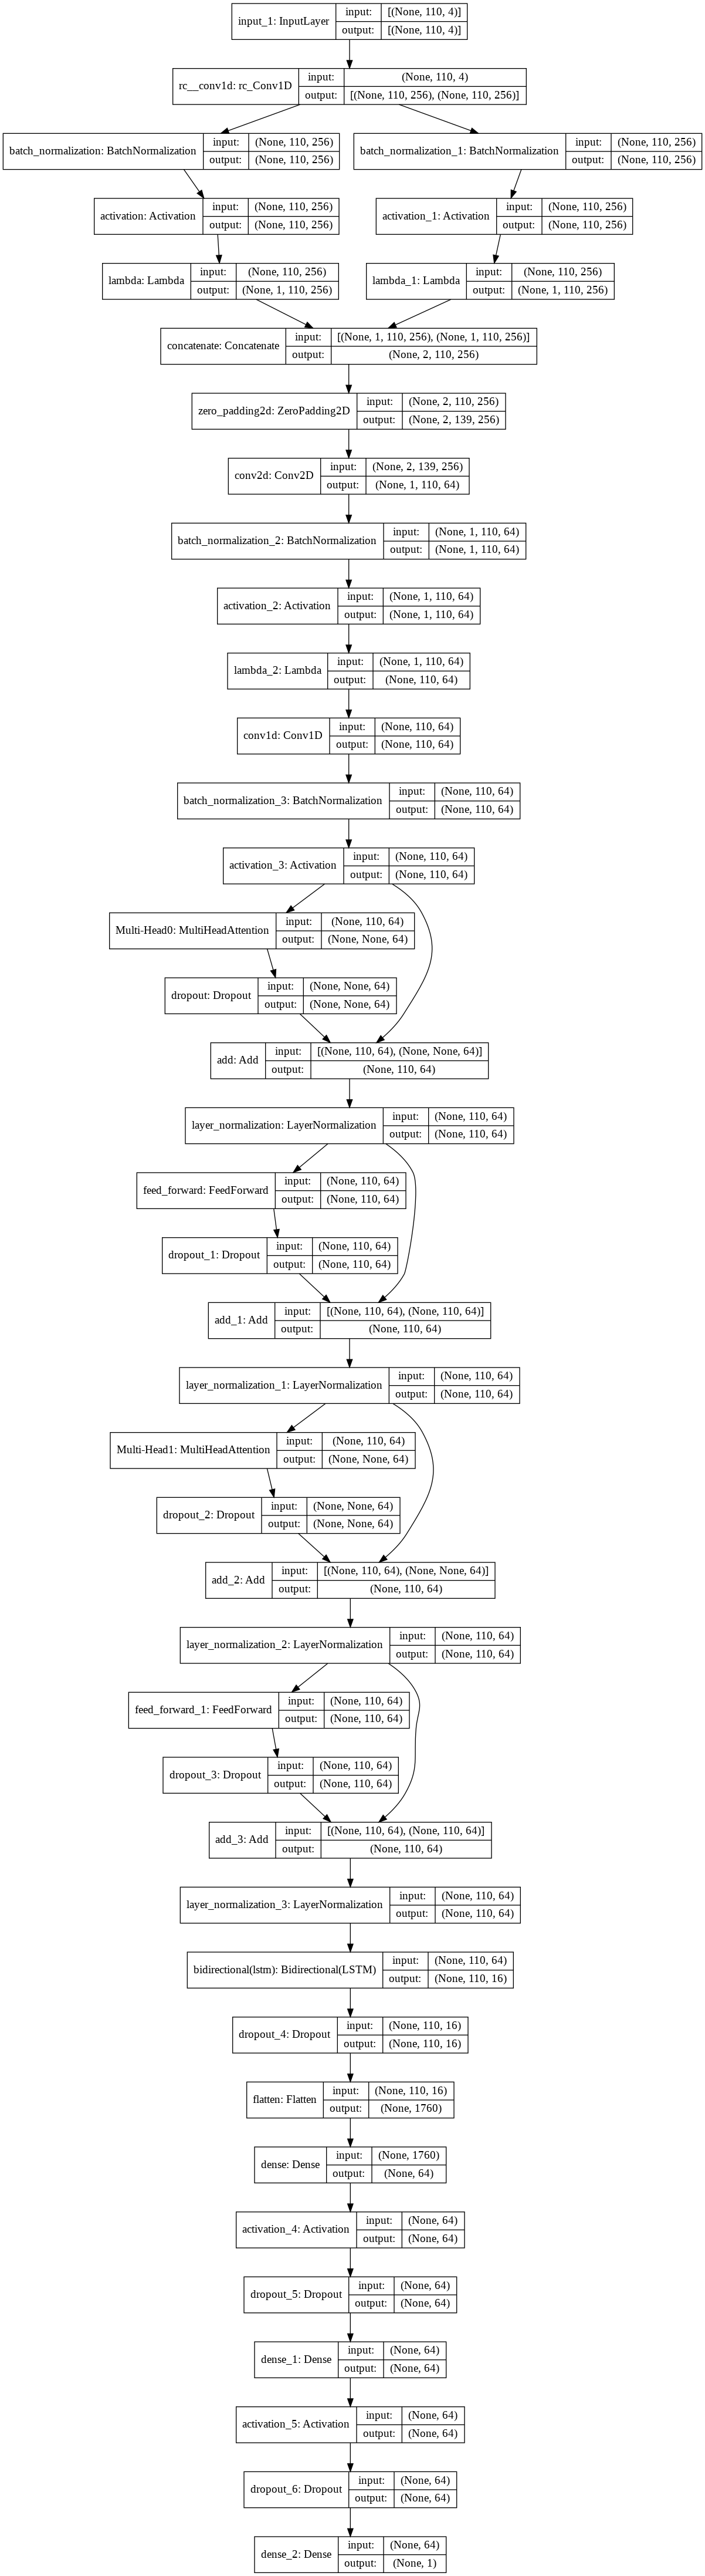

In [49]:
plot_model(model, show_shapes = 1 , show_layer_names = 1 ,to_file='model.png')

In [50]:
### Randomly select dataset for the generator for the common model
class DataGenerator(keras.utils.Sequence):
    #https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly


    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=32, shuffle=True ):
        'Initialization'
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        if self.shuffle == True:
            return int(np.floor(len(self.list_IDs) / self.batch_size))
        else:
            return int(np.ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        if self.shuffle == True:
            indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        else:
            indexes = self.indexes[index*self.batch_size:np.minimum(len(self.list_IDs),(index+1)*self.batch_size)]    

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        batch_X , batch_Y = self.__data_generation(list_IDs_temp)
        return  (batch_X , batch_Y)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp ):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        batch_X = trX[list_IDs_temp]
        batch_Y = trY[list_IDs_temp]


        return batch_X , batch_Y

In [51]:
if 0 : 
    params_train = {
              'batch_size': batch_size,
              'shuffle': True,
              }
    len_list_IDs = trX.shape[0]

    # Datasets
    partition = {'train': np.arange(len_list_IDs) }
    training_generator = DataGenerator(partition['train'], **params_train)
    example_batch = training_generator[0]


In [52]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
history = LossHistory()

csvlogger = keras.callbacks.CSVLogger(os.path.join(dir_path,"loss_history.tsv"), separator='\t', append=False)
tensorboard = keras.callbacks.TensorBoard(log_dir=os.path.join(dir_path,"logs", 
                                                               datetime.datetime.now().strftime("%Y%m%d-%H%M%S")),
                                          update_freq='batch', histogram_freq=0, batch_size=batch_size, write_graph=True, 
                            write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, 
                            embeddings_metadata=None, embeddings_data=None)


checkpoint = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/AAV2_viability_DeepAttn-regression/aav2_DNAregressor.h5', 
                                             monitor='val_loss', 
                                             verbose=1, save_best_only=True, mode='min')

# check 5 epochs
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, mode='min') 

callbacks_list = [checkpoint, early_stop, history , tensorboard , csvlogger]


In [53]:
model.fit(trX, trY, validation_data = (vaX, vaY),
          batch_size=batch_size  , epochs=epochs , callbacks=callbacks_list )

Train on 193408 samples, validate on 20489 samples
Epoch 1/100
192512/193408 [============================>.] - ETA: 0s - loss: 0.5888 - r_square: 0.4112
Epoch 00001: val_loss improved from inf to 2.97720, saving model to /content/drive/MyDrive/AAV2_viability_DeepAttn-regression/aav2_DNAregressor.h5
193408/193408 [==============================] - 148s 764us/sample - loss: 0.5873 - r_square: 0.4130 - val_loss: 2.9772 - val_r_square: -2.0257
Epoch 2/100
192512/193408 [============================>.] - ETA: 0s - loss: 0.2646 - r_square: 0.7350
Epoch 00002: val_loss improved from 2.97720 to 0.27090, saving model to /content/drive/MyDrive/AAV2_viability_DeepAttn-regression/aav2_DNAregressor.h5
193408/193408 [==============================] - 142s 734us/sample - loss: 0.2644 - r_square: 0.7353 - val_loss: 0.2709 - val_r_square: 0.7026
Epoch 3/100
192512/193408 [============================>.] - ETA: 0s - loss: 0.2018 - r_square: 0.7979
Epoch 00003: val_loss did not improve from 0.27090
1934

In [54]:
#model.fit_generator(training_generator, validation_data = (vaX, vaY),
#epochs=epochs , steps_per_epoch = int(trX.shape[0]/(batch_size*n_val_epoch)) , callbacks=callbacks_list )




if 0:
    model = load_model('keras_model.h5' , custom_objects={
        'MultiHeadAttention' : MultiHeadAttention , 
        'FeedForward' : FeedForward,
        'correlation_coefficient' : correlation_coefficient,
        'LayerNormalization' : LayerNormalization,
        'rc_Conv1D' : rc_Conv1D})

# Evaluate model

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/AAV2_viability_DeepAttn-regression/aav2_DNAregressor.h5')

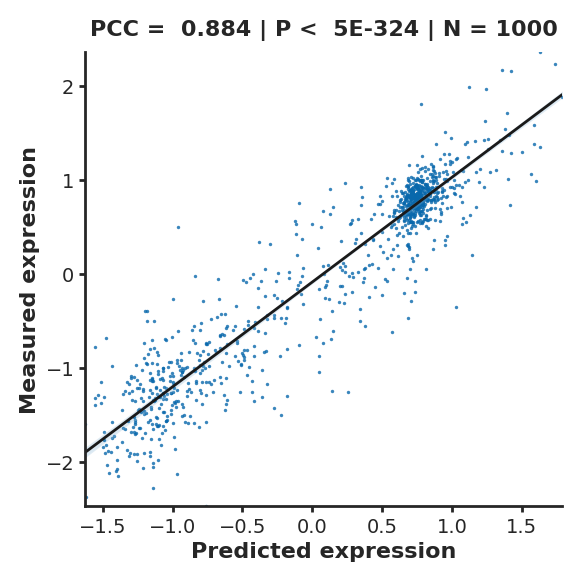

In [55]:
x=model.predict(teX)
y=teY

r = scipy.stats.spearmanr(model.predict(teX),teY)

import seaborn as sns
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(3,3) , dpi= 200, facecolor='w', edgecolor='k')
fig.tight_layout(pad = 1)

if 1 : 
    sns.regplot(x=x ,y=y ,
                scatter_kws= {'s':1.5,'linewidth':0, 'rasterized':True} ,
                line_kws= {'linewidth':1} ,
                color= '#0868ac', robust = 1 )
else : 
    sns.scatterplot(x,y, s = 1 , linewidth = 0 , rasterized = 1,
               color= '#0868ac')


ax = plt.gca()
ax.set_xlabel("Predicted expression")
ax.set_ylabel("Measured expression")

if (r[1] ==0.0) :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P < {np.nextafter(0, 1) : 0.0E} | N = {len(x)}"  )
else :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P = {r[1] : 0.2E} | N = {len(x)}"  )

plt.setp(ax.artists, edgecolor = 'k')
plt.setp(ax.lines, color='k')
#plt.setp(ax.lines, linewidth=1.5)

ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
#ax.set_xlim(xmin=-3,xmax=3)
#ax.set_ylim(ymin=-3,ymax=3)

plt.show()

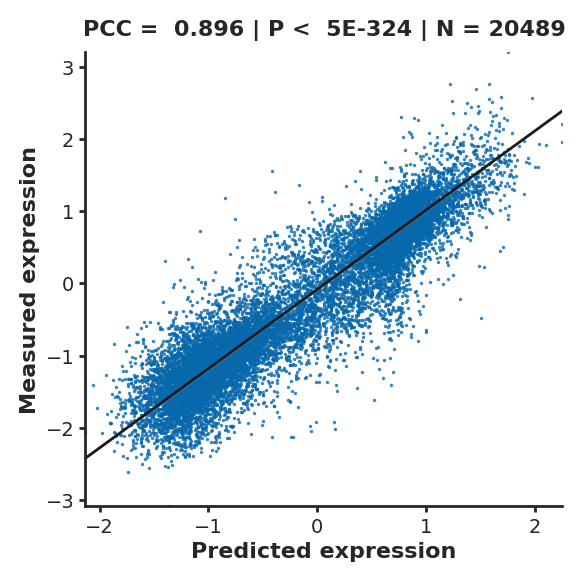

In [56]:
x=model.predict(vaX)
y=vaY

r = scipy.stats.spearmanr(model.predict(vaX),vaY)

import seaborn as sns
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(3,3) , dpi= 200, facecolor='w', edgecolor='k')
fig.tight_layout(pad = 1)

if 1 : 
    sns.regplot(x=x ,y=y ,
                scatter_kws= {'s':1.5,'linewidth':0, 'rasterized':True} ,
                line_kws= {'linewidth':1} ,
                color= '#0868ac', robust = 1 )
else : 
    sns.scatterplot(x,y, s = 1 , linewidth = 0 , rasterized = 1,
               color= '#0868ac')


ax = plt.gca()
ax.set_xlabel("Predicted expression")
ax.set_ylabel("Measured expression")

if (r[1] ==0.0) :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P < {np.nextafter(0, 1) : 0.0E} | N = {len(x)}"  )
else :
    ax.set_title(f"PCC = {r[0] : 0.3f} | P = {r[1] : 0.2E} | N = {len(x)}"  )

plt.setp(ax.artists, edgecolor = 'k')
plt.setp(ax.lines, color='k')
#plt.setp(ax.lines, linewidth=1.5)

ax.autoscale(enable=True, axis='x', tight=True)
ax.autoscale(enable=True, axis='y', tight=True)
#ax.set_xlim(xmin=-3,xmax=3)
#ax.set_ylim(ymin=-3,ymax=3)

plt.show()